In [289]:
# load the python modules we will use
import uproot # for data loading
import awkward as ak # for data manipulation
import hist # for histogram filling (and some plotting)
import pandas as pd
import matplotlib as mpl # for plotting
import matplotlib.pyplot as plt # common shorthand
from mpl_toolkits.mplot3d import Axes3D
import mplhep # style of plots
import numpy as np
%matplotlib inline
mpl.style.use(mplhep.style.ROOT) # set the plot style
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

## Reconstruction efficiency

Number of reconstructed events / how many LHE events run

In [350]:


processes = ['prima', 'pf']
masses = [10, 200, 500]

data = {'Process': processes}
for mass in masses:
    data[mass] = []

events_ran = 50000

for process in processes:
    for mass in masses:
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
            print(len(events))
            data[mass].append(len(events) * 100 / events_ran)


df = pd.DataFrame(data)

df





1146
12518
23187
7546
9329
13309


,Process,10,200,500
0,prima,2.292,25.036,46.374
1,pf,15.092,18.658,26.618


## Signal yield
not factoring in selection and triggering

In [338]:
processes = ['prima', 'pf']
masses = [10, 200, 500]

sig_yield = {'Process': processes}
for mass in masses:
    sig_yield[mass] = []

N_prod_proc = {'Process': processes}
N_prod_proc[10] = [1340, 139]
N_prod_proc[200] = [140, 24]
N_prod_proc[500] = [20, 3]


for i, process in enumerate(processes):
    for j, mass in enumerate(masses):
        reco_eff = data[mass][i] / 100
        sig_yield[mass].append(N_prod_proc[mass][i] * reco_eff)
        


df = pd.DataFrame(sig_yield)

df

,Process,10,200,500
0,prima,30.71280,35.05040,9.27480
1,pf,20.97788,4.47792,0.79854


why does it behave like this


## Visualizations - experiment

In [341]:
with uproot.open('ALP_mall_PN_ntuple.root') as f:
    tree = f['Features']
    df = tree.arrays(library='np')
    features = tree.keys()

df['Xs']


array([array([ 132.65942 ,  103.04811 ,  -95.23061 , -375.      , -175.      ,
              -125.      , -180.62971 , -172.7015  , -301.25372 , -117.178505,
              -125.      ,  -75.      ,   25.      , -289.6453  , -175.      ,
              -225.      , -775.      , -825.      ,   15.34075 , -462.34076 ,
              -462.34076 ,   15.34075 , -462.34076 , -462.34076 ,   15.34075 ,
              -462.34076 , -462.34076 ,   65.34075 , -462.34076 ,   65.34075 ,
              -362.34076 ,  115.34075 , -362.34076 , -362.34076 ,  462.34076 ,
               462.34076 , -115.34075 ,  462.34076 ,  462.34076 ,  462.34076 ,
               -65.34075 ,  362.34076 , -215.34074 ,  262.34076 , -265.34076 ,
              -165.34074 ,  262.34076 , -474.34076 , -474.34076 , -606.34076 ,
              -606.34076 , -650.34076 , -650.34076 , -694.34076 , -694.34076 ,
              -738.34076 , -782.34076 , -782.34076 ], dtype=float32)          ,
       array([-169.5093   , -225.       ,  225.    

nhits - number of reconstructed hits
zlength - longest distance on z axis
zaverage - average

In [342]:
all_xs = [hit for event in df['Xs'] for hit in event]
all_ys = [hit for event in df['Ys'] for hit in event]
all_zs = [hit for event in df['Zs'] for hit in event]

photons_x = [hit for event in df['Xs'] for hit in event[:2]]
photons_y = [hit for event in df['Ys'] for hit in event[:2]]
photons_z = [hit for event in df['Zs'] for hit in event[:2]]

         

In [343]:
df['Zs'][4][:5]

array([ 879., 1712., 1810., 1859., 1957.], dtype=float32)

Text(0, 1, 'Y in mm')

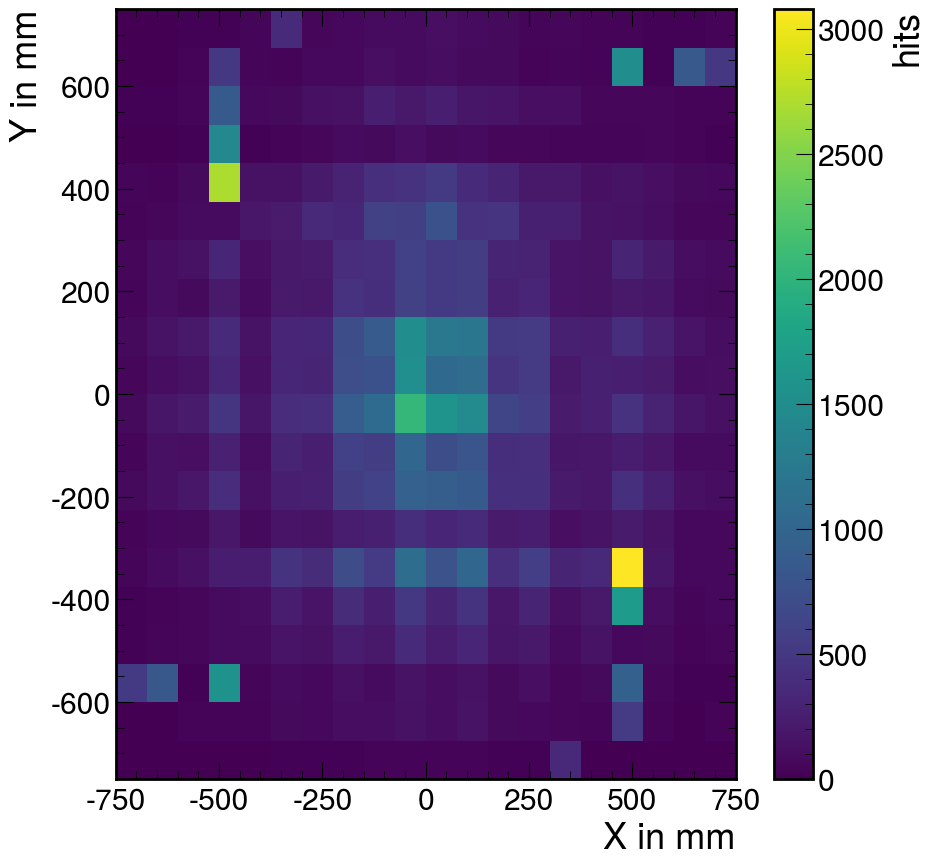

In [344]:
fig, ax = plt.subplots(1,1)

h, xedges, yedges, image = ax.hist2d(all_xs, all_ys,
                                       range=[[-750,750],[-750,750]],
                                       bins=20,
                                       cmap='viridis')
cbar = plt.colorbar(image, ax=ax)
cbar.set_label('hits')
ax.set_xlabel('X in mm')
ax.set_ylabel('Y in mm')



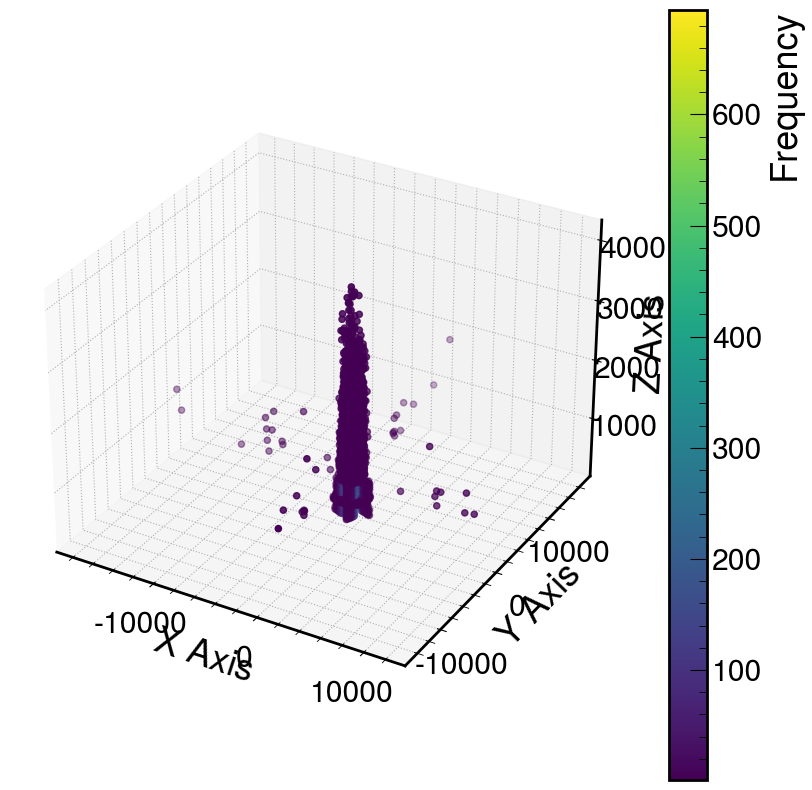

In [345]:
data = np.vstack([all_xs, all_ys, all_zs]).T

hist, edges = np.histogramdd(data, bins=300)

# Get the center of each bin
xedges, yedges, zedges = edges
xbins = 0.5 * (xedges[:-1] + xedges[1:])
ybins = 0.5 * (yedges[:-1] + yedges[1:])
zbins = 0.5 * (zedges[:-1] + zedges[1:])
# Create meshgrid
xgrid, ygrid, zgrid = np.meshgrid(xbins, ybins, zbins, indexing='ij')

# Flatten the arrays
xflat = xgrid.ravel()
yflat = ygrid.ravel()
zflat = zgrid.ravel()
freq = hist.ravel()

# Filter out zero frequencies for better visualization
nonzero = freq > 0
xflat = xflat[nonzero]
yflat = yflat[nonzero]
zflat = zflat[nonzero]
freq = freq[nonzero]

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xflat, yflat, zflat, c=freq, cmap='viridis')

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Frequency')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.show()


In [346]:
import nbformat
print(nbformat.__version__)

5.10.4


In [347]:
fig = go.Figure(data=[go.Scatter3d(
    x=xflat,
    y=yflat,
    z=zflat,
    mode='markers',
    marker=dict(
        size=5,
        color=freq,
        colorscale='Viridis',
        colorbar=dict(title='Frequency')
    )
)])

fig.update_layout(
    title='background hits',
    scene=dict(
                xaxis=dict(title='X Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                yaxis=dict(title='Y Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                zaxis=dict(title='Z Axis (mm)', 
                           range=[0, 4000]
                           )
    )
)

fig.show()

## 3D visualization

In [354]:

for j, mass in enumerate(masses):

    for i, process in enumerate(processes):
   
        with uproot.open(f'ALP_m{mass}_{process}_ntuple_ecal.root') as f:
            events = f['Features'].arrays(library='np')

        all_xs = [hit for event in events['Xs'] for hit in event]
        all_ys = [hit for event in events['Ys'] for hit in event]
        all_zs = [hit for event in events['Zs'] for hit in event]
        
        photons_x = [hit for event in df['Xs'] for hit in event[:2]]
        photons_y = [hit for event in df['Ys'] for hit in event[:2]]
        photons_z = [hit for event in df['Zs'] for hit in event[:2]]

        data = np.vstack([all_xs, all_ys, all_zs]).T
        #data = np.vstack([photons_x, photons_y, photons_z]).T

        # Calculate the 3D histogram
        hist, edges = np.histogramdd(data, bins=100)

        # Get the center of each bin
        xedges, yedges, zedges = edges
        xbins = 0.5 * (xedges[:-1] + xedges[1:])
        ybins = 0.5 * (yedges[:-1] + yedges[1:])
        zbins = 0.5 * (zedges[:-1] + zedges[1:])

        # Create meshgrid
        xgrid, ygrid, zgrid = np.meshgrid(xbins, ybins, zbins, indexing='ij')

# Flatten the arrays
        xflat = xgrid.ravel()
        yflat = ygrid.ravel()
        zflat = zgrid.ravel()
        freq = hist.ravel()

        # Filter out zero frequencies for better visualization
        nonzero = freq > 0
        xflat = xflat[nonzero]
        yflat = yflat[nonzero]
        zflat = zflat[nonzero]
        freq = freq[nonzero]

        # Plot the interactive 3D scatter plot
        fig = go.Figure(data=[go.Scatter3d(
            x=xflat,
            y=yflat,
            z=zflat,
            mode='markers',
            marker=dict(
                size=5,
                color=freq,
                colorscale='Viridis',
                colorbar=dict(title='Frequency')
            )
        )])

        fig.update_layout(
            title=f'All Photon hits for m{mass}_{process}',
            scene=dict(
                xaxis=dict(title='X Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                yaxis=dict(title='Y Axis (mm)', 
                           range=[-1500, 1500]
                           ),
                zaxis=dict(title='Z Axis (mm)', 
                           range=[0, 3000]
                           )
            )
        )

        fig.show()

KeyError: 'Xs'

## Playing around


3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698
3698


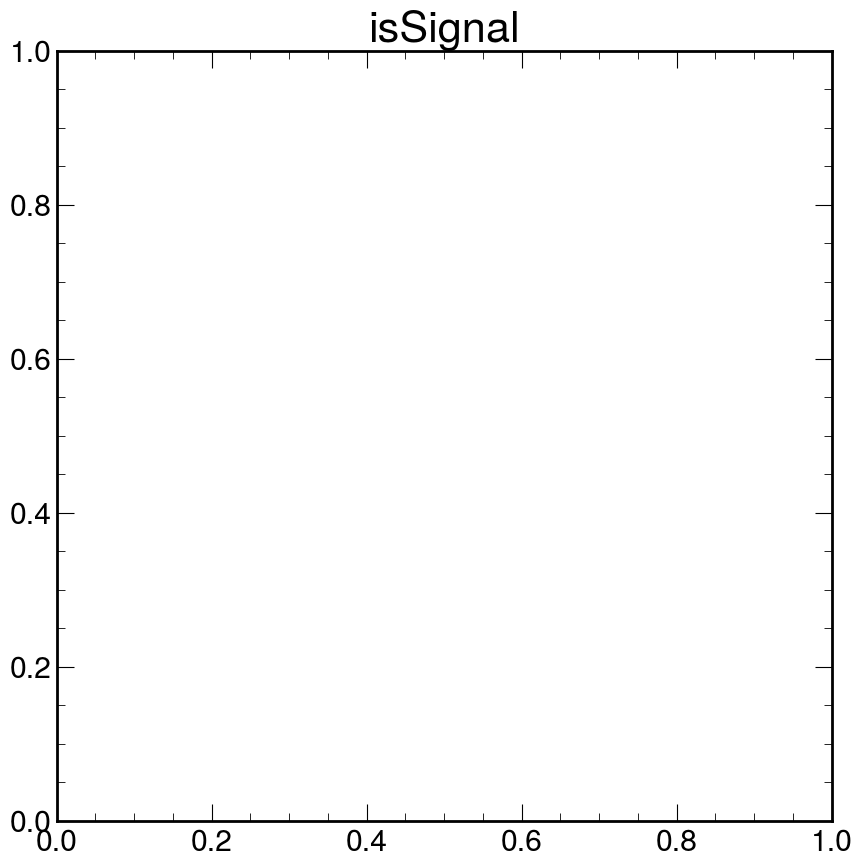

In [300]:
for feature in features:

    #fig, ax = plt.subplots(1, 1)
    #n, bins, patches = ax.hist(df[feature])
    ax.set_yscale('log')
    plt.title(feature)
    print(len(df[feature]))
    



NameError: name 'pz' is not defined

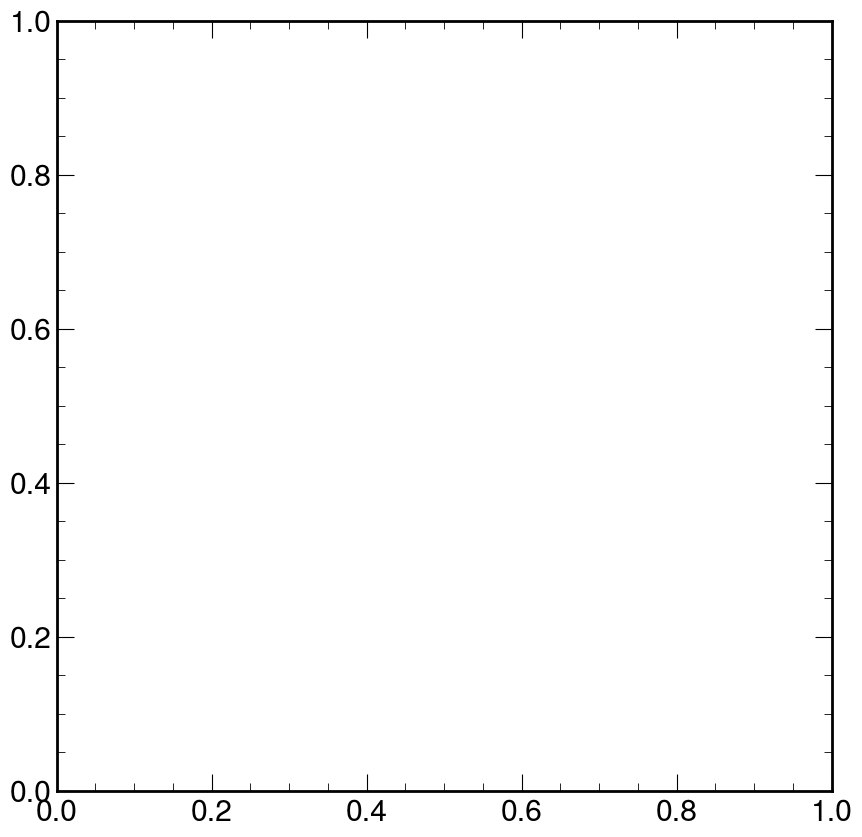

In [301]:
fig, ax = plt.subplots(1,1)
h, xedges, yedges, image = ax.hist2d(pz, zangle, bins=100, range=[[0,8],[0,0.5*math.pi]], cmap=plt.cm.viridis)
cbar = plt.colorbar(image, ax=ax)

## Histograms with BKGD

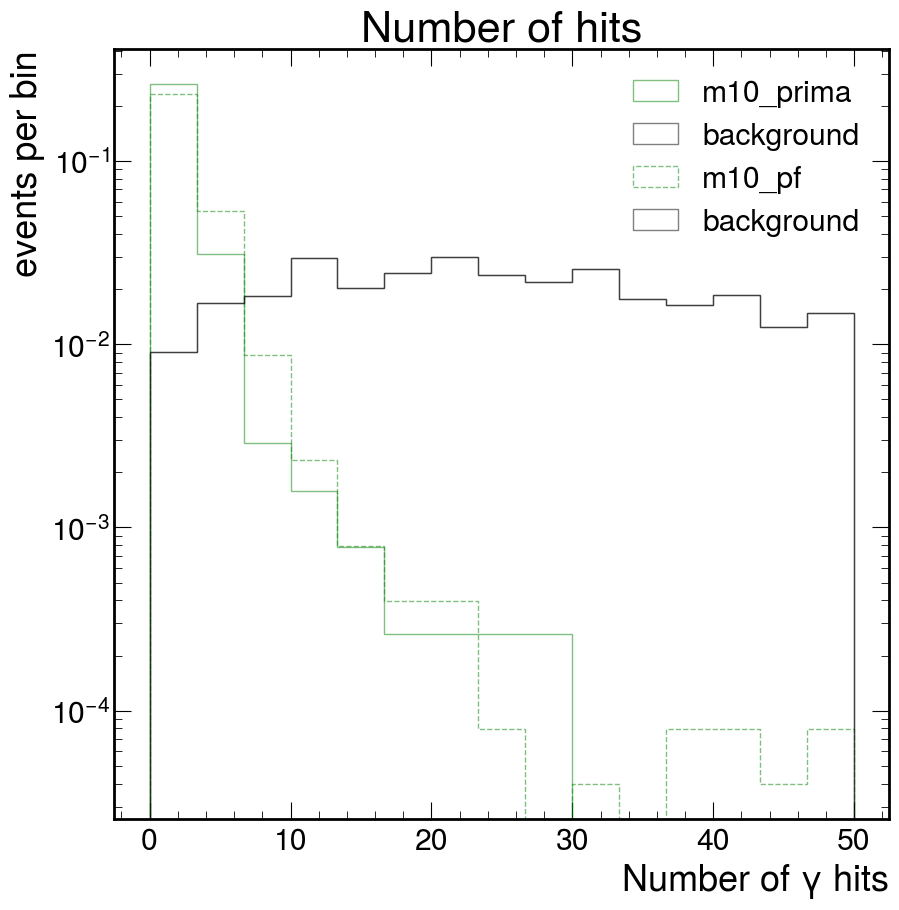

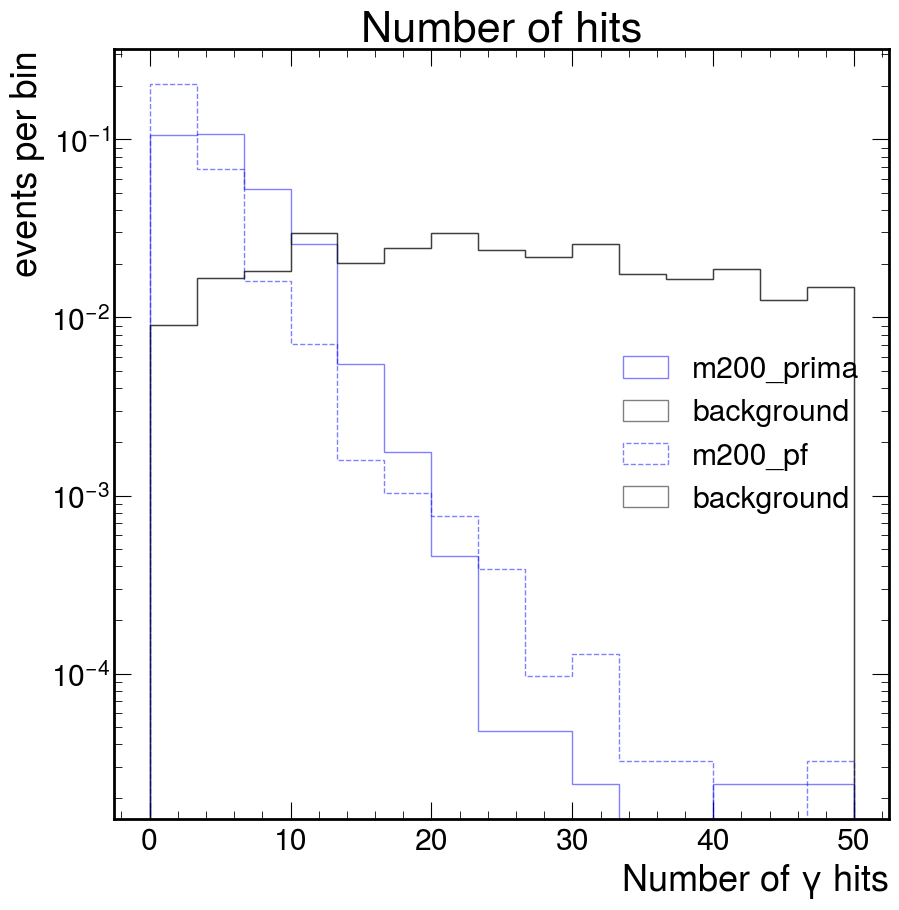

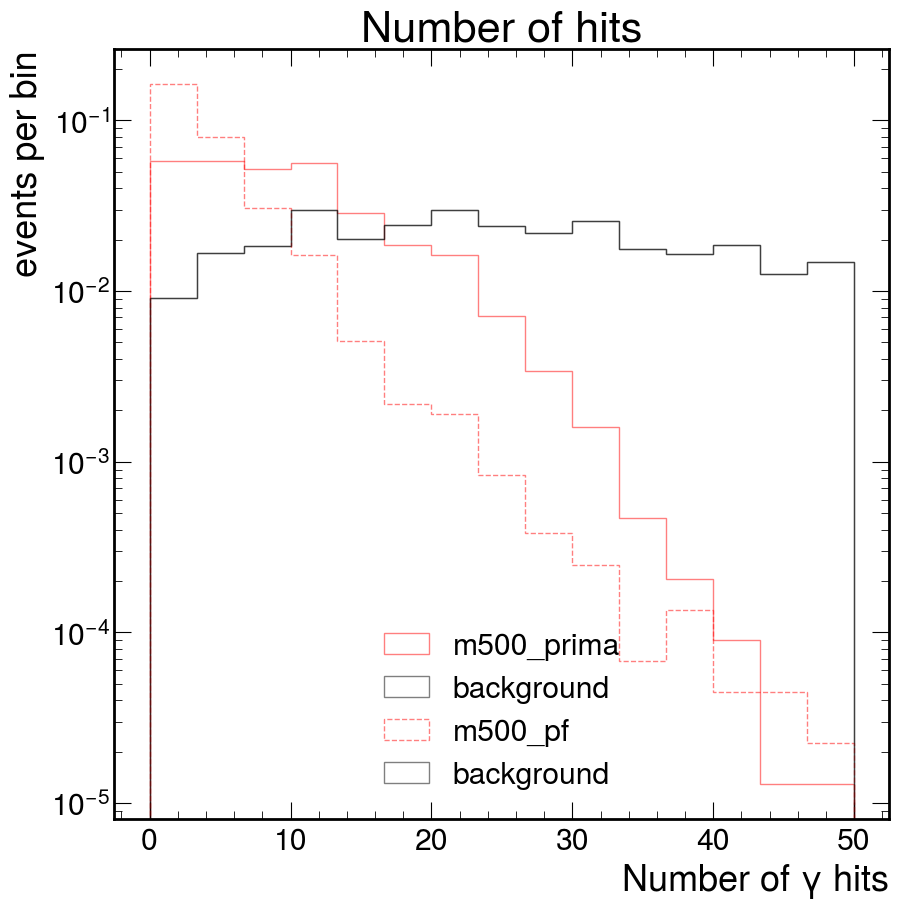

In [352]:
with uproot.open(f'ALP_mall_PN_ntuple.root') as f:
    bkgd = f['Features'].arrays()

styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]

for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)

    for i, process in enumerate(processes):
   
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("Number of hits")
        n, bins, patches = ax.hist(events['NHits'],
                                   histtype = 'step',
                                   bins=15,
                                   range=(0,50),
                                   density=True,
                                   linestyle = styles[i],
                                   color = colors[j],
                                   alpha=0.5,
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['NHits'],
                                    histtype = 'step',
                                    bins=15,
                                    range=(0,50),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label=f'background')

        plt.legend()
        ax.set_yscale('log')
        ax.set_ylabel('events per bin')
        ax.set_xlabel('Number of $\gamma$ hits')          

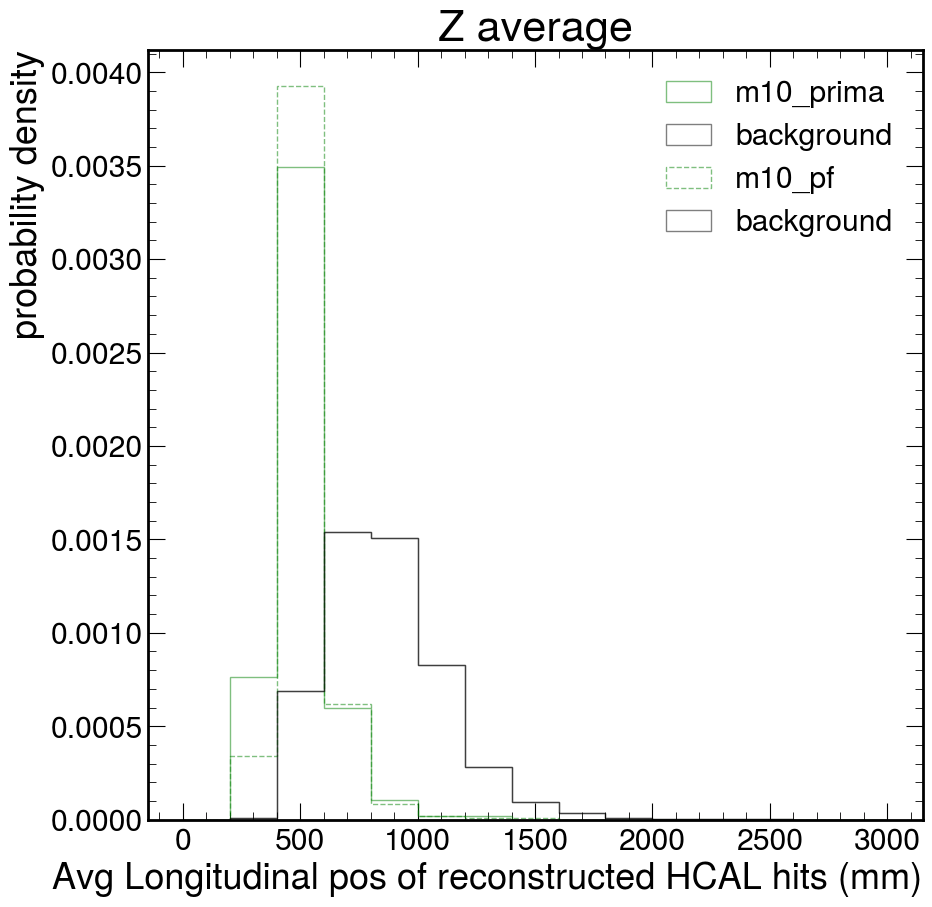

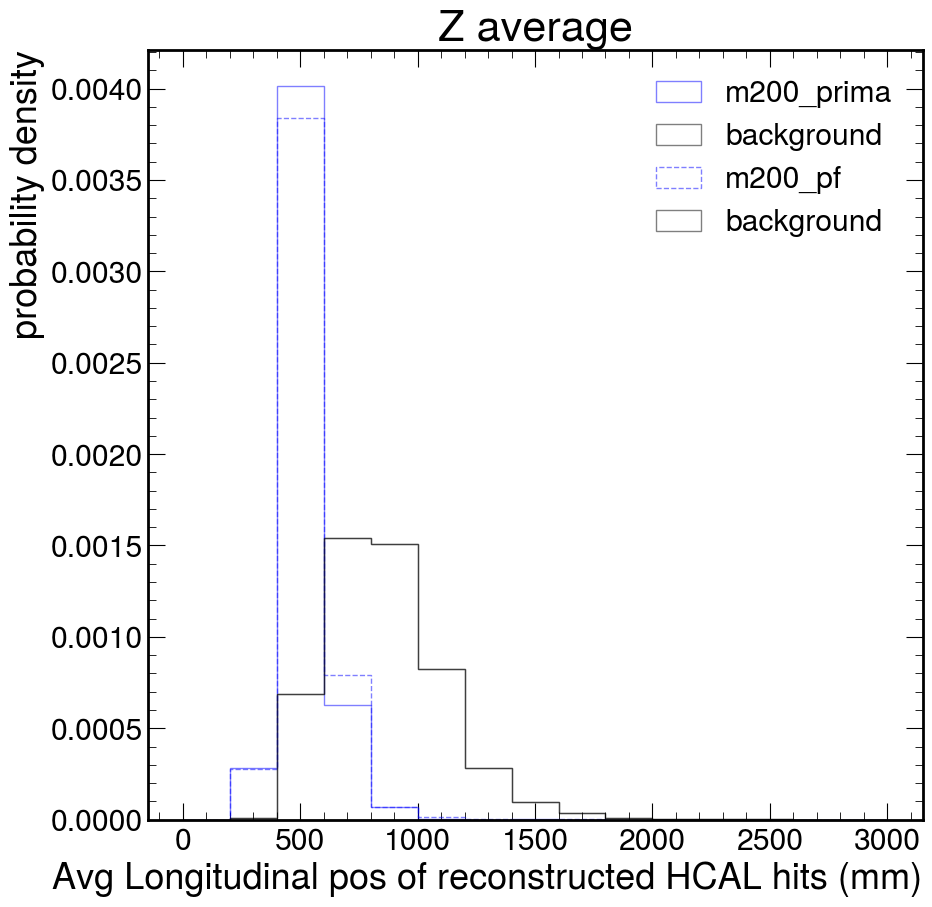

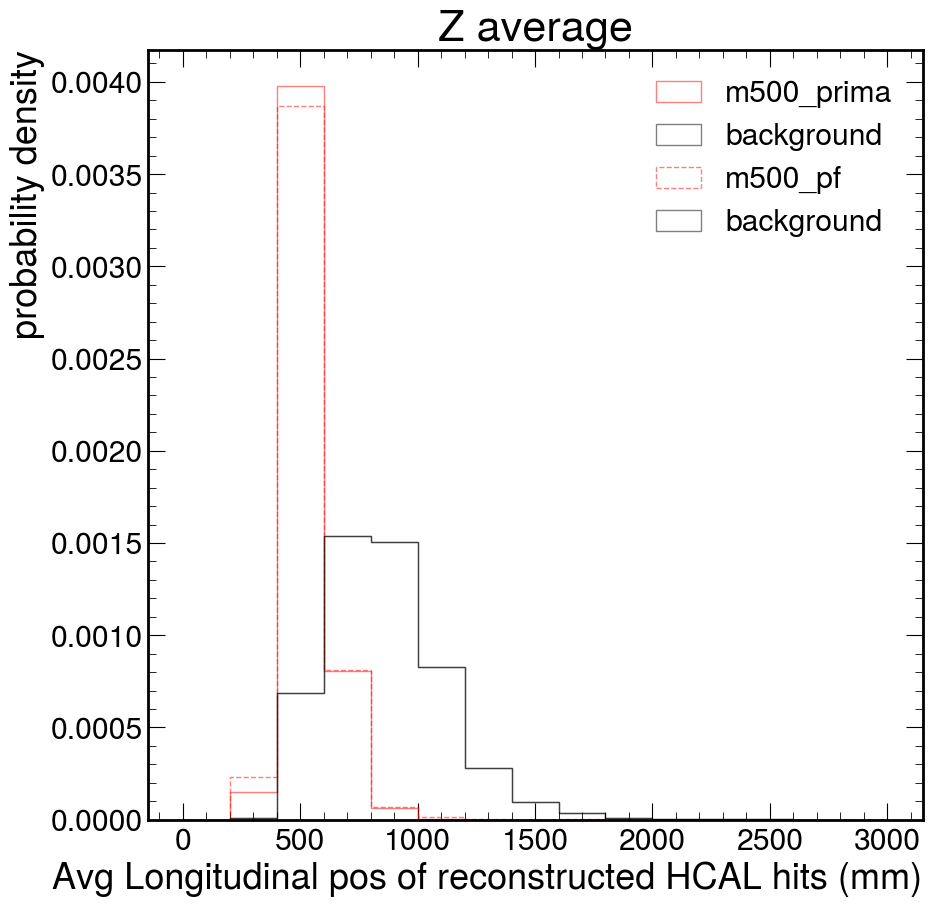

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]

    

for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("Z average")
        n, bins, patches = ax.hist(events['ZAv'],
                                   histtype = 'step',
                                   density=True,
                                   bins=15,
                                   linestyle = styles[i],
                                   color = colors[j],
                                   alpha=0.5,
                                   range=(0,3000),
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['ZAv'],
                                    histtype = 'step',
                                    bins=15,
                                    range=(0,3000),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label=f'background')
        plt.legend()
        #ax.set_yscale('log')
        ax.set_ylabel('probability density')
        ax.set_xlabel('Avg Longitudinal pos of reconstructed HCAL hits (mm)')

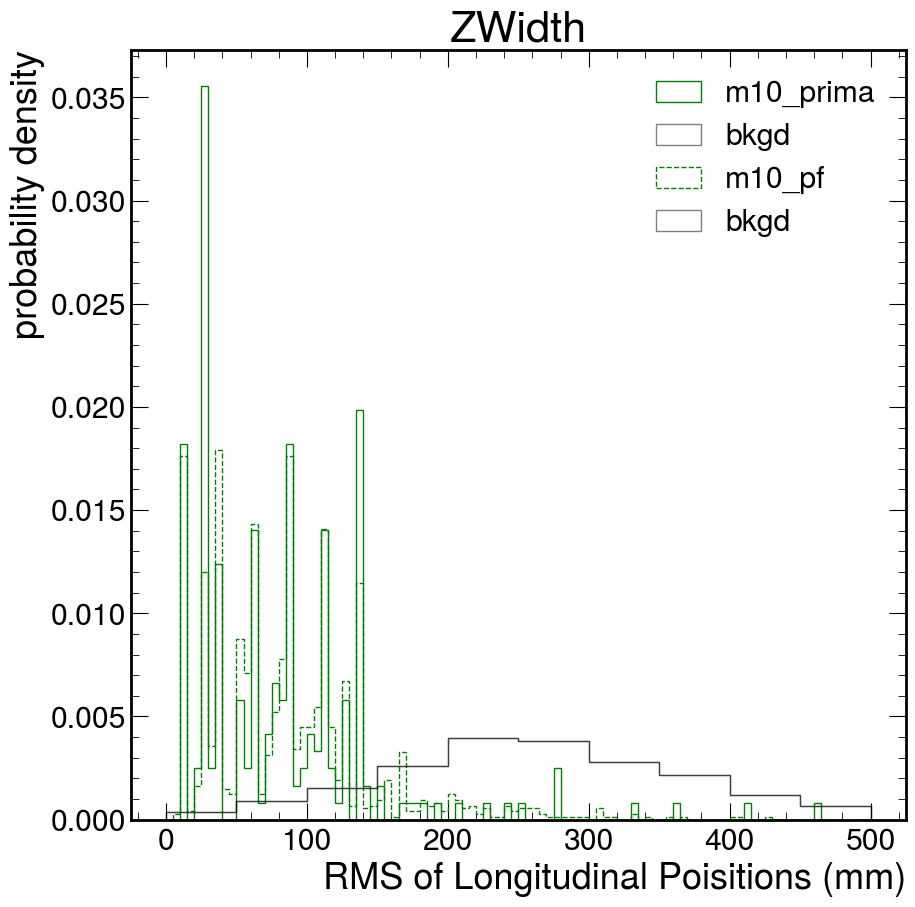

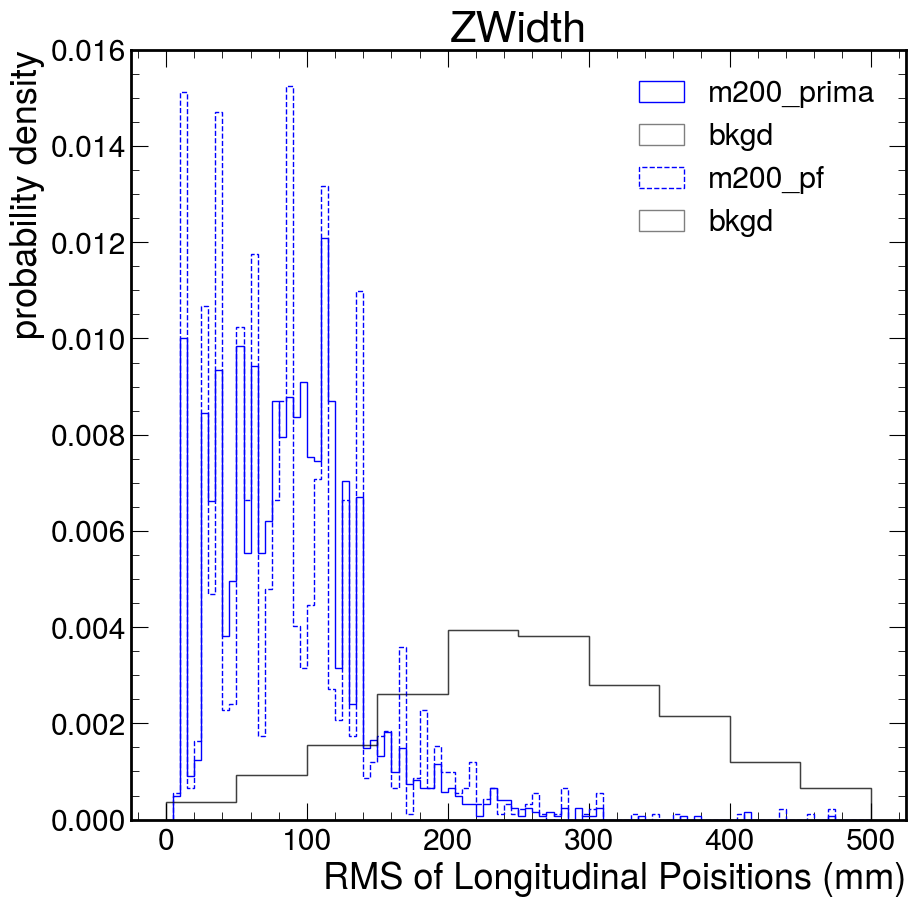

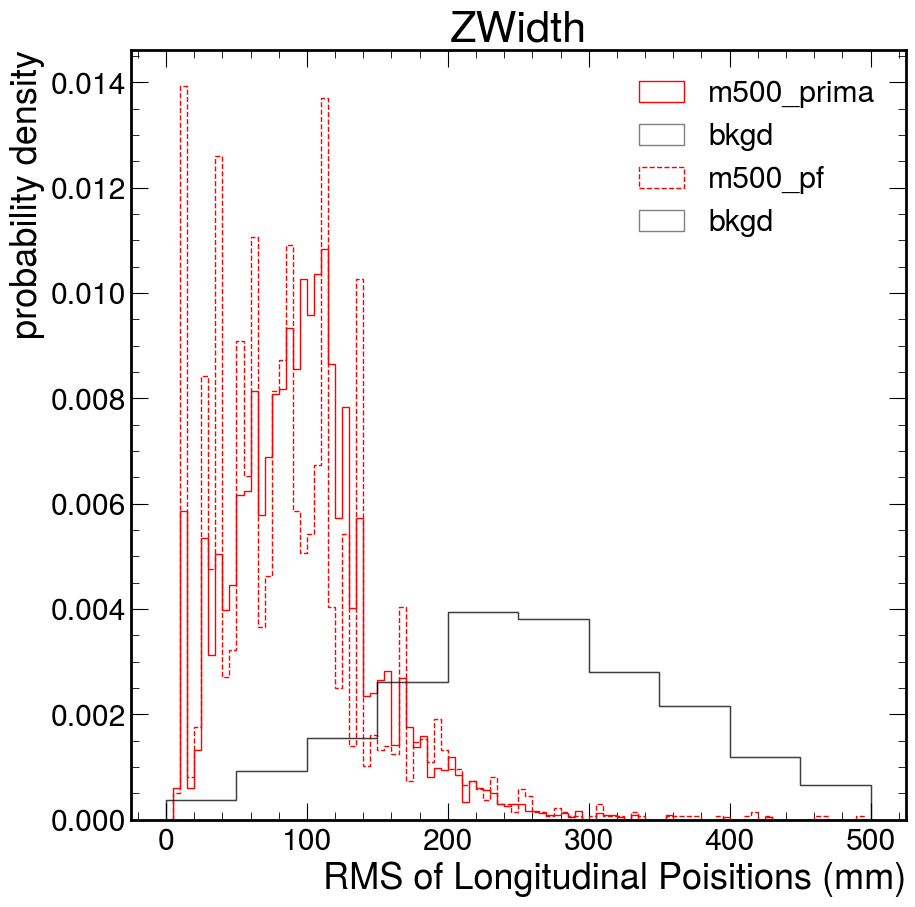

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("ZWidth")
        n, bins, patches = ax.hist(events['ZWidth'],
                                   histtype = 'step',
                                   density=True,
                                   bins=100,
                                   range=(0,500),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['ZWidth'],
                                    histtype = 'step',
                                    bins=10,
                                    range=(0,500),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label=f'bkgd')
    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel("RMS of Longitudinal Poisitions (mm)")

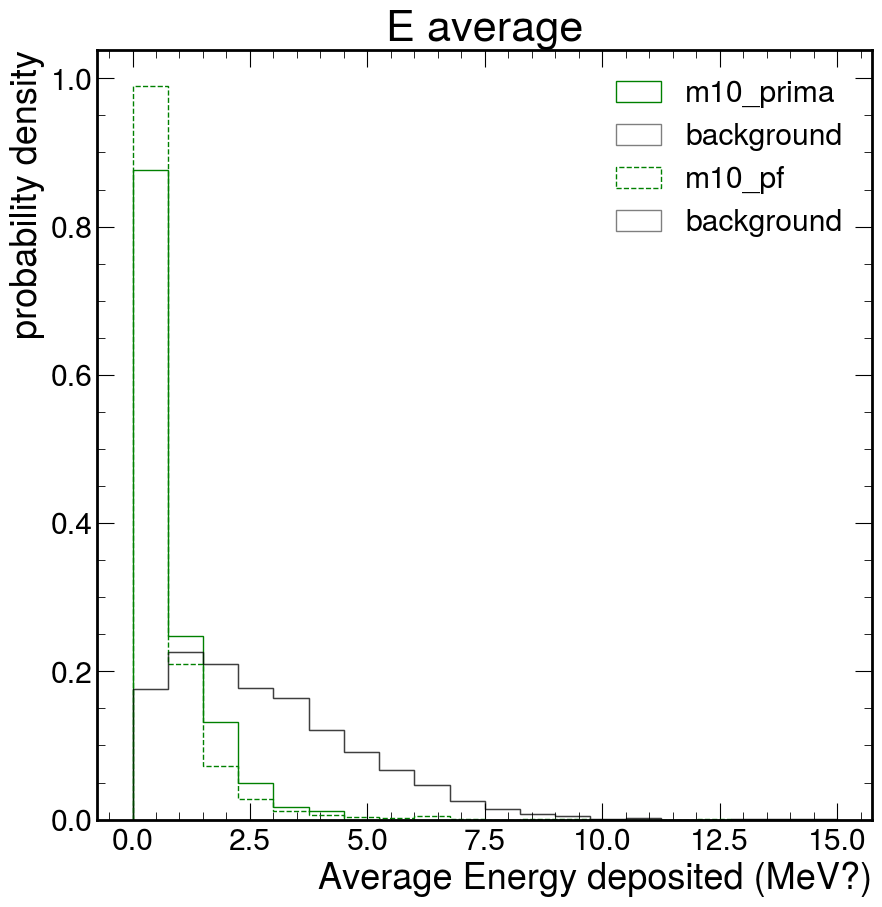

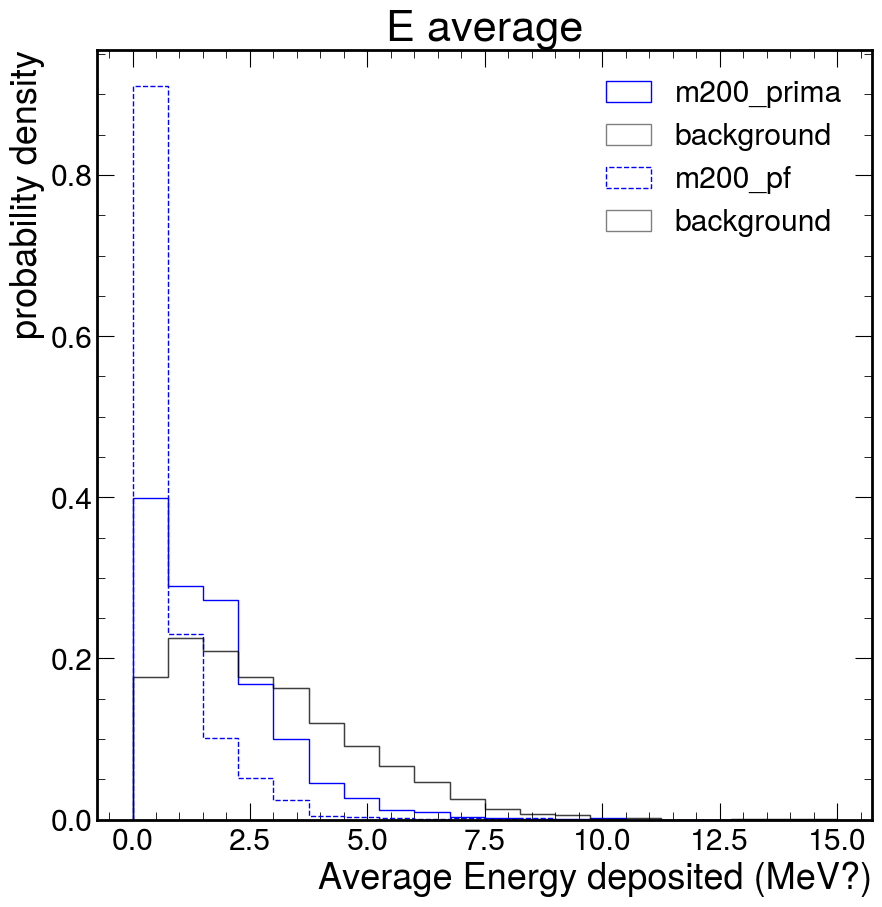

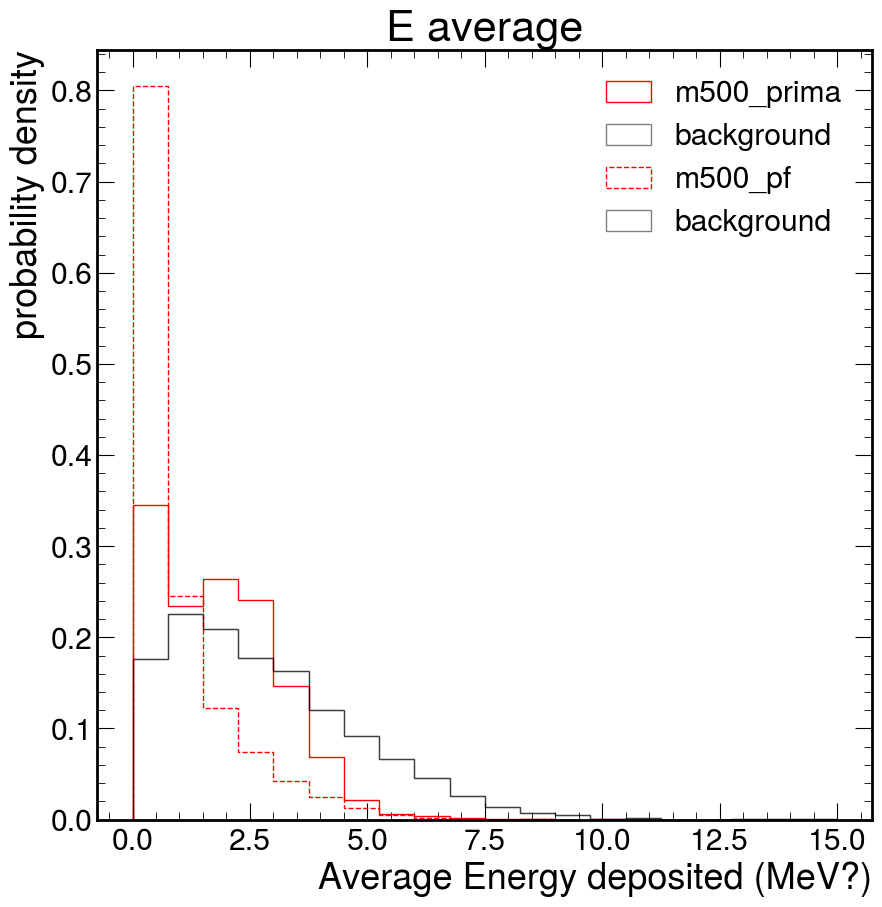

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate(masses):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m{mass}_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("E average")
        n, bins, patches = ax.hist(events['Eav'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,15),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['Eav'],
                                    histtype = 'step',
                                    bins=20,
                                    range=(0,15),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Energy deposited (MeV?)')

In [ ]:
with uproot.open(f'ALP_m10_pf_ntuple.root') as f:
    events = f['Features'].arrays()

fig, ax = plt.subplots(1, 2)
n, bins, patches = ax[0].hist(events['XYAv'],
                              histtype = 'step'
                              density=True,
                              bins=20,
                              range=(0,1500),
                              

SyntaxError: '(' was never closed (3530394385.py, line 5)

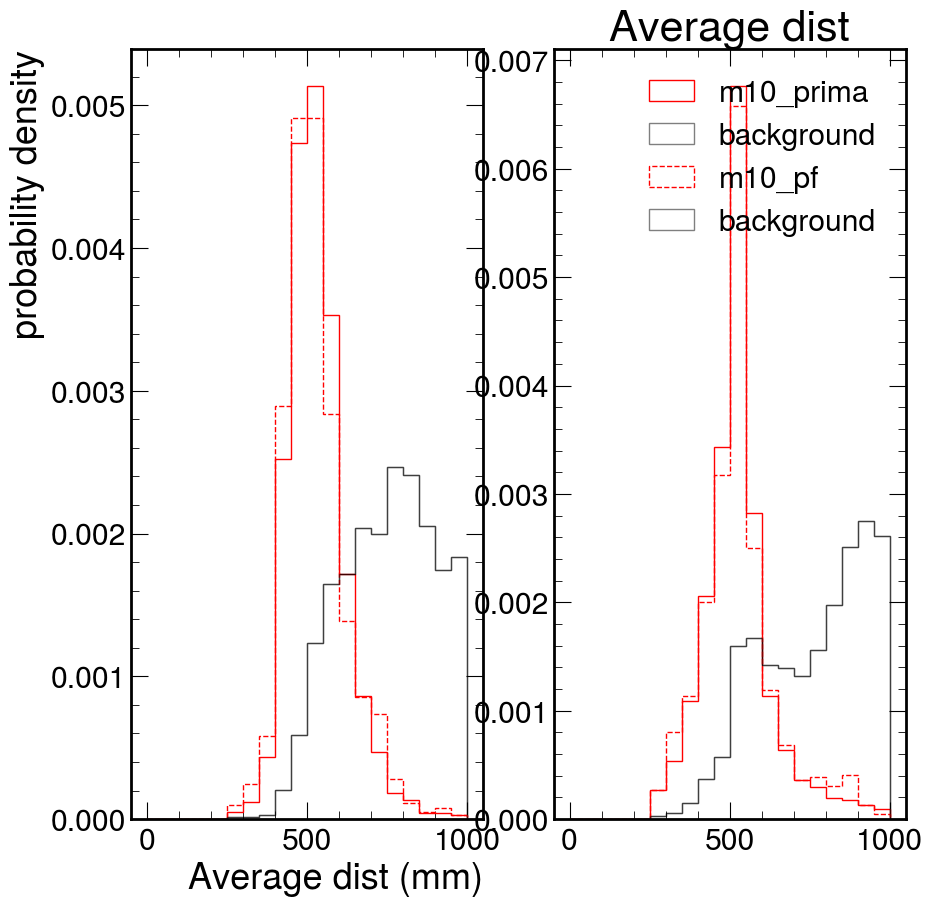

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
#for j, mass in enumerate(masses):
fig, ax = plt.subplots(1, 2)
for i, process in enumerate(processes):

    with uproot.open(f'ALP_m500_{process}_ntuple.root') as f:
        events = f['Features'].arrays()
    plt.title("Average dist")
    n, bins, patches = ax[0].hist(events['ZAv'],
                                histtype = 'step',
                                density=True,
                                bins=20,
                                range=(0,1000),
                                linestyle = styles[i],
                                color = colors[j],
                                label=f'm10_{process}')
    n, bins, patches = ax[0].hist(bkgd['ZAv'],
                                histtype = 'step',
                                bins=20,
                                range=(0,1000),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label='background')
    n, bins, patches = ax[1].hist(events['ZAverage_w'],
                                histtype = 'step',
                                density=True,
                                bins=20,
                                range=(0,1000),
                                linestyle = styles[i],
                                color = colors[j],
                                label=f'm10_{process}')
    n, bins, patches = ax[1].hist(bkgd['ZAverage_w'],
                                histtype = 'step',
                                bins=20,
                                range=(0,1000),
                                density=True,
                                linestyle = 'solid',
                                color = 'black',
                                alpha=0.5,
                                label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax[0].set_ylabel('probability density')
    ax[0].set_xlabel('Average dist (mm)')

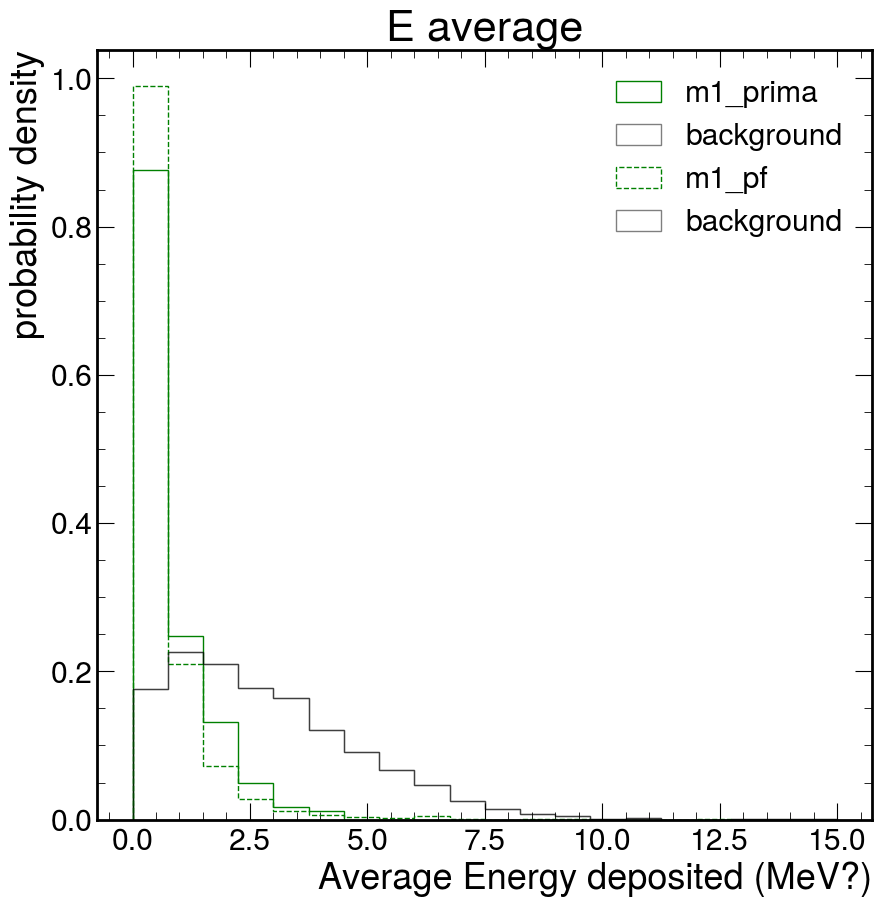

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate([1]):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m10_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("E average")
        n, bins, patches = ax.hist(events['Eav'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,15),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['Eav'],
                                    histtype = 'step',
                                    bins=20,
                                    range=(0,15),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Energy deposited (MeV?)')

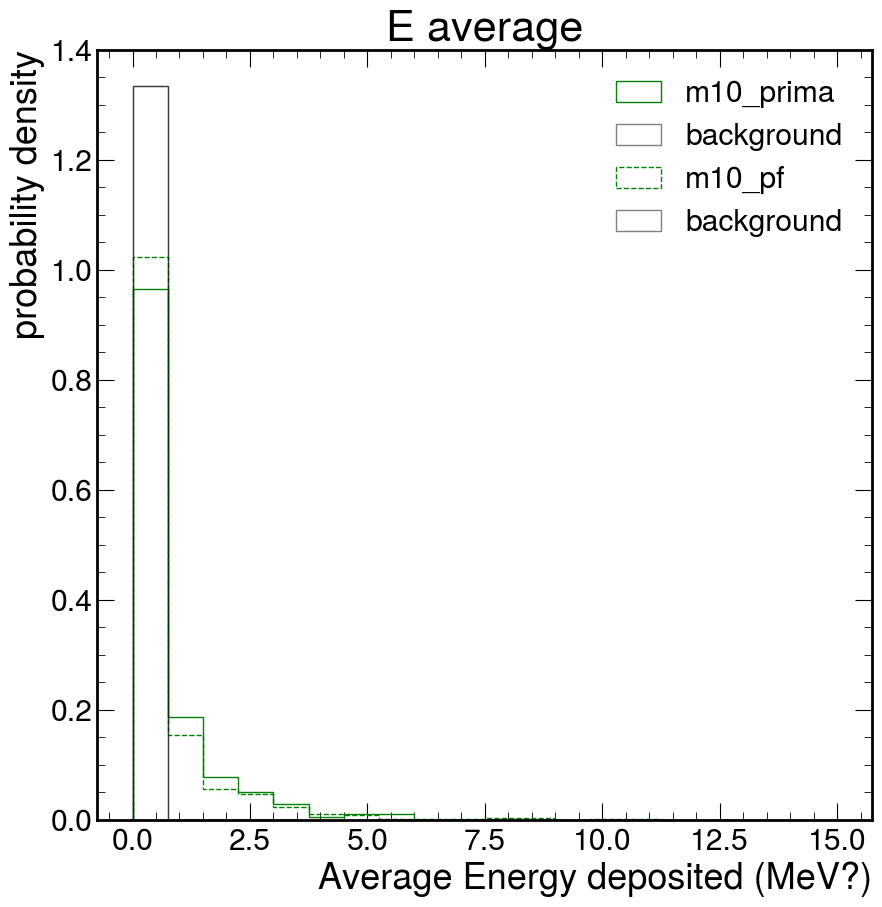

In [ ]:
styles = ["solid", 'dashed']
colors = ["green", "blue", "red"]
for j, mass in enumerate([10]):
    fig, ax = plt.subplots(1, 1)
    for i, process in enumerate(processes):
    
        with uproot.open(f'ALP_m10_{process}_ntuple.root') as f:
            events = f['Features'].arrays()
        plt.title("E average")
        n, bins, patches = ax.hist(events['Eav_cut_2'],
                                   histtype = 'step',
                                   density=True,
                                   bins=20,
                                   range=(0,15),
                                   linestyle = styles[i],
                                   color = colors[j],
                                   label=f'm{mass}_{process}')
        n, bins, patches = ax.hist(bkgd['Eav_cut_3'],
                                    histtype = 'step',
                                    bins=20,
                                    range=(0,15),
                                    density=True,
                                    linestyle = 'solid',
                                    color = 'black',
                                    alpha=0.5,
                                    label='background')

    plt.legend()
    #ax.set_yscale('log')
    ax.set_ylabel('probability density')
    ax.set_xlabel('Average Energy deposited (MeV?)')

## Observations from generator plots

* Photons scatter more from ALP in Primakoff process than photon fusion
* More extreme behavior at 10 MeV / c^2 but spread is proportional to mass of ALP
* In primakoff, photons have less z momentum (makes sense because scatter more)

## Observations from reconstructed histograms

* Regarding number of hits
    * It is more likely for photon fusion to get a hit than primakoff at 200 and 500 MeV
    * However, primakoff has a higher chance of recording a larger number of hits
    * This is opposite at 10 MeV

* Average z of hits
    * More likely for photon fusion photons to get farther
    * At 10 this is the opposite, as the mode for primakoff is farther than mode of photon fusion
    * Photon fusion has more standard deviation

*  E deposited
    * for 200 and 500 MeV, higher energy deposits more likely with primakoff, until >8 GeV, when photon fusion more likely, which is very rare
    * Primakoff yields more low energy deposits at 10 and 200, but photon fusion for 500



## Figuring out where to cut

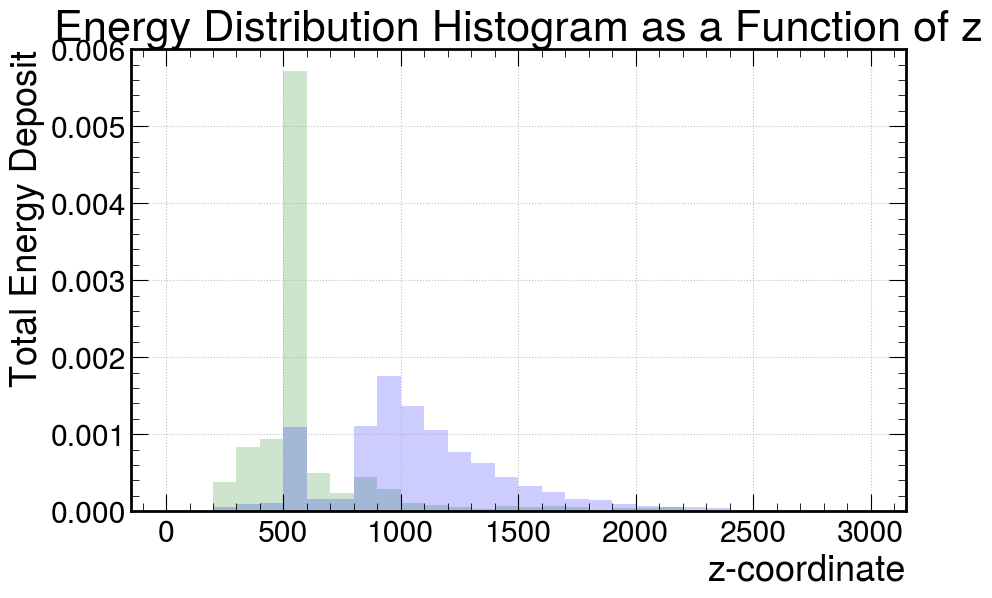

In [302]:
## need to figure out where most of the energy is deposited, 
with uproot.open(f'ALP_mall_PN_ntuple.root') as f:
    bkgd = f['Features'].arrays()

bkgd_es = [hit for event in bkgd['Es'] for hit in event]
bkgd_zs = [hit for event in bkgd['Zs'] for hit in event]

with uproot.open('ALP_m500_pf_ntuple.root') as f:
    tree = f['Features']
    df = tree.arrays(library='np')
    features = tree.keys()

all_zs = [hit for event in df['Zs'] for hit in event]
all_es = [hit for event in df['Es'] for hit in event]


plt.figure(figsize=(10, 6))
plt.hist(all_zs, bins=30, weights=all_es, color='green', alpha=0.2, range=(0,3000), density=True)
plt.hist(bkgd_zs, bins=30, weights=bkgd_es, color='blue', alpha=0.2, range=(0,3000), density=True)
plt.xlabel('z-coordinate')
plt.ylabel('Total Energy Deposit')
plt.title('Energy Distribution Histogram as a Function of z')
plt.grid(True)
plt.show()

## Exploring data for BDT

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import datasets
from sklearn import svm

In [319]:
with uproot.open("ALP_m200_prima_ntuple.root") as f:
    signal = f['Features'].arrays(library='pd')

with uproot.open("ALP_mall_PN_ntuple.root") as f:
    bkgd = f['Features'].arrays(library='pd')

#assigning labels
signal['Label'] = 'signal'
bkgd['Label'] = 'bkgd'

signal['Label'] = signal.Label.astype('category')
bkgd['Label'] = bkgd.Label.astype('category')


ex = pd.read_csv('training_10k.csv')

data = pd.concat([bkgd, signal], ignore_index=True)

data['Label'] = pd.Categorical(data['Label'])

col = np.r_[1:5, 9: ]
features = data.columns[:-2]
features = features.drop(['Xs', 'Ys', 'Zs', 'Es'])
data

,NHits,ZLength,ZAverage_w,XAverage,YAverage,Ys,Xs,Zs,Es,ZWidth_w,...,XYWidth,XYWidth_w,DeltaZ,Eav,EDensity,Eav_cut_1,Eav_cut_2,Eav_cut_3,isSignal,Label
0,58.0,1347.0,918.694580,0.0,0.0,"[-505.95001220703125, -455.95001220703125, -10...","[132.659423828125, 103.04811096191406, -95.230...","[879.0, 879.0, 977.0, 1026.0, 1026.0, 1026.0, ...","[0.1644705832004547, 0.750300407409668, 0.1480...",369.403076,...,278.745361,256.195831,221.736954,2.617293,0.112697,1.643774,5.172781,0.0,1,bkgd
1,38.0,1368.0,1189.747925,0.0,0.0,"[-305.95001220703125, -266.7337341308594, -279...","[-169.50929260253906, -225.0, 225.0, -153.7086...","[879.0, 928.0, 928.0, 977.0, 977.0, 1026.0, 10...","[6.2248029708862305, 6.343637466430664, 0.2032...",179.958328,...,156.024933,178.888519,186.574432,5.351840,0.148662,4.286121,6.535973,0.0,1,bkgd
2,11.0,1025.0,1261.431641,0.0,0.0,"[544.0499877929688, 644.0499877929688, 594.049...","[179.52452087402344, -235.5379638671875, -177....","[977.0, 1075.0, 1173.0, 1516.0, 1565.0, 540.0,...","[4.933355808258057, 0.15302535891532898, 0.412...",363.978638,...,135.891769,99.051483,760.142944,3.781373,0.040581,1.945009,12.045013,0.0,1,bkgd
3,19.0,807.0,826.446899,0.0,0.0,"[144.0500030517578, 11.4361572265625, -140.443...","[-271.1487731933594, -175.0, -25.0, -122.05738...","[879.0, 928.0, 928.0, 977.0, 977.0, 1026.0, 10...","[0.19132399559020996, 0.1973647028207779, 0.31...",261.768677,...,200.737106,249.034698,338.237427,0.545311,0.012839,0.361835,0.749173,0.0,1,bkgd
4,31.0,1692.0,790.061340,0.0,0.0,"[-405.95001220703125, -377.91876220703125, -29...","[346.59381103515625, 175.0, 375.0, 82.21863555...","[879.0, 1712.0, 1810.0, 1859.0, 1957.0, 540.0,...","[0.21381177008152008, 5.667489051818848, 3.397...",496.449890,...,220.588333,139.104111,177.459427,1.542247,0.028256,1.453034,2.006150,0.0,1,bkgd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,2.0,464.0,604.394714,0.0,0.0,"[-405.95001220703125, 619.0499877929688]","[-36.17112350463867, 518.3407592773438]","[879.0, 415.0]","[0.2495570182800293, 0.3618353009223938]",228.054352,...,199.922485,196.522385,56.591297,0.305696,0.001318,0.361835,0.249557,0.0,1,signal
6110,8.0,562.0,617.493530,0.0,0.0,"[344.04998779296875, -446.95001220703125, 144....","[295.5601501464844, 462.34075927734375, 474.34...","[977.0, 415.0, 540.0, 615.0, 540.0, 540.0, 765...","[0.3793213665485382, 0.1644705832004547, 0.789...",153.330704,...,142.224899,132.986862,90.160454,0.411306,0.005855,0.416659,0.395249,0.0,1,signal
6111,3.0,225.0,545.311157,0.0,0.0,"[-314.95001220703125, -314.95001220703125, 619...","[434.65924072265625, 484.65924072265625, 518.3...","[540.0, 540.0, 765.0]","[7.121576309204102, 0.3618353009223938, 0.1809...",34.158489,...,119.054947,41.709595,319.989258,2.554776,0.034064,3.741706,0.180918,0.0,1,signal
6112,10.0,610.0,847.440552,0.0,0.0,"[-320.71453857421875, -71.86302947998047, -311...","[575.0, 625.0, 575.0, 625.0, 437.8281555175781...","[928.0, 928.0, 1026.0, 1026.0, 1075.0, 540.0, ...","[0.49378785490989685, 0.18450425565242767, 2.9...",143.701859,...,60.139946,37.676464,345.557068,1.099424,0.018023,1.358527,0.840320,0.0,1,signal


In [305]:
#splitting in testing and training
features = data.columns[:-2]

X = data[features]
y = data['Label']

skf = StratifiedKFold(n_splits=3)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")
    
    # Splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Check the distribution of labels in each set
    print("Train label distribution:\n", y_train.value_counts())
    print("Test label distribution:\n", y_test.value_counts())
    print("-" * 40)

# ratios are preserved

Fold 1
Train label distribution:
 Label
bkgd      2465
signal    1611
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1233
signal     805
Name: count, dtype: int64
----------------------------------------
Fold 2
Train label distribution:
 Label
bkgd      2465
signal    1611
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1233
signal     805
Name: count, dtype: int64
----------------------------------------
Fold 3
Train label distribution:
 Label
bkgd      2466
signal    1610
Name: count, dtype: int64
Test label distribution:
 Label
bkgd      1232
signal     806
Name: count, dtype: int64
----------------------------------------


In [309]:
with uproot.open("ALP_m200_prima_ntuple.root") as f:
    signal = f['Features'].arrays(library='pd')

with uproot.open("ALP_mall_PN_ntuple.root") as f:
    bkgd = f['Features'].arrays(library='pd')

signal


,NHits,ZLength,ZAverage_w,XAverage,YAverage,Ys,Xs,Zs,Es,ZWidth_w,...,XYAv_w,XYWidth,XYWidth_w,DeltaZ,Eav,EDensity,Eav_cut_1,Eav_cut_2,Eav_cut_3,isSignal
0,3.0,250.0,617.272705,0.0,0.0,"[-358.95001220703125, 194.0500030517578, -580....","[462.34075927734375, -562.3407592773438, -606....","[665.0, 540.0, 415.0]","[0.674329400062561, 0.11512941122055054, 0.115...",87.551636,...,618.919556,117.741936,84.383492,289.969696,0.301529,0.003618,0.115129,0.674329,0.0,1
1,2.0,175.0,502.254913,0.0,0.0,"[353.04998779296875, 397.04998779296875]","[-134.6592559814453, -462.34075927734375]","[540.0, 365.0]","[0.6578823328018188, 0.1809176504611969]",71.977081,...,427.806152,115.786636,95.245529,172.401962,0.419400,0.004793,0.180918,0.657882,0.0,1
2,7.0,513.0,557.733276,0.0,0.0,"[-361.382568359375, -314.95001220703125, -314....","[375.0, -215.3407440185547, -165.3407440185547...","[928.0, 540.0, 540.0, 540.0, 540.0, 415.0, 665.0]","[0.19093240797519684, 0.06578823179006577, 0.1...",99.763657,...,356.442352,111.746132,87.085564,322.026367,0.464298,0.006335,0.595384,0.136584,0.0,1
3,3.0,275.0,303.150299,0.0,0.0,"[-5.949999809265137, -580.9500122070312, -155....","[474.34075927734375, -606.3407592773438, -650....","[540.0, 265.0, 540.0]","[0.4934117794036865, 4.901223659515381, 0.2960...",95.057274,...,799.161438,149.257965,106.995987,127.186897,1.896894,0.020693,4.901224,0.394729,0.0,1
4,6.0,225.0,344.901947,0.0,0.0,"[194.0500030517578, -480.95001220703125, -255....","[474.34075927734375, -870.3407592773438, -914....","[540.0, 315.0, 540.0, 365.0, 415.0, 465.0]","[0.1809176504611969, 8.536023139953613, 0.9045...",73.114021,...,993.758667,267.224457,87.718956,209.648697,1.677600,0.044736,8.536023,0.305915,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,2.0,464.0,604.394714,0.0,0.0,"[-405.95001220703125, 619.0499877929688]","[-36.17112350463867, 518.3407592773438]","[879.0, 415.0]","[0.2495570182800293, 0.3618353009223938]",228.054352,...,644.195251,199.922485,196.522385,56.591297,0.305696,0.001318,0.361835,0.249557,0.0,1
2412,8.0,562.0,617.493530,0.0,0.0,"[344.04998779296875, -446.95001220703125, 144....","[295.5601501464844, 462.34075927734375, 474.34...","[977.0, 415.0, 540.0, 615.0, 540.0, 540.0, 765...","[0.3793213665485382, 0.1644705832004547, 0.789...",153.330704,...,600.619812,142.224899,132.986862,90.160454,0.411306,0.005855,0.416659,0.395249,0.0,1
2413,3.0,225.0,545.311157,0.0,0.0,"[-314.95001220703125, -314.95001220703125, 619...","[434.65924072265625, 484.65924072265625, 518.3...","[540.0, 540.0, 765.0]","[7.121576309204102, 0.3618353009223938, 0.1809...",34.158489,...,545.105103,119.054947,41.709595,319.989258,2.554776,0.034064,3.741706,0.180918,0.0,1
2414,10.0,610.0,847.440552,0.0,0.0,"[-320.71453857421875, -71.86302947998047, -311...","[575.0, 625.0, 575.0, 625.0, 437.8281555175781...","[928.0, 928.0, 1026.0, 1026.0, 1075.0, 540.0, ...","[0.49378785490989685, 0.18450425565242767, 2.9...",143.701859,...,607.244080,60.139946,37.676464,345.557068,1.099424,0.018023,1.358527,0.840320,0.0,1


In [333]:
np.random.rand(1)

array([0.82713015])